In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from subprocess import check_output
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time #helper libraries
from sklearn import preprocessing
import matplotlib.pyplot as plt
from numpy import newaxis
from datetime import datetime

Using TensorFlow backend.


In [2]:
input_data = pd.read_csv("2330.csv")

In [3]:
input_data.head()

,證券代碼,年月日,開盤價(元),最高價(元),最低價(元),收盤價(元),成交量(千股),外資買賣超(千股),投信買賣超(千股),自營買賣超(千股),外資總投資股率%,投信持股率%,自營持股率%
0,2330 台積電,1/2/2008,39.58,39.58,38.43,38.62,"38,970",394,"-8,824",-365,71.79,0.53,0.02
1,2330 台積電,1/3/2008,38.24,38.30,37.92,37.92,"34,838","-9,307",-804,482,71.76,0.52,0.02
2,2330 台積電,1/4/2008,37.86,38.56,37.34,38.30,"48,400","-6,802","-1,357",711,71.73,0.52,0.02
3,2330 台積電,1/7/2008,36.39,37.03,35.62,35.62,"103,229","-65,640","-5,021","-1,424",71.48,0.50,0.02
4,2330 台積電,1/8/2008,35.62,36.13,35.43,35.75,"47,333","-13,831",77,"-1,248",71.43,0.50,0.01


In [4]:
def transform(x):
    try:
        return x.replace(",", "")
    except:
        return x

input_data.iloc[:, 2:] = input_data.iloc[:, 2:].applymap(lambda x: float(transform(x)))

In [5]:
input_data = input_data.iloc[:, 2:]

In [6]:
columns = ['open', 'high', 'low', 'close', 'volume',
           'foreign', 'trust', 'dealer',
           'foreign_ratio', 'trust_ratio', 'dealer_ratio']

input_data.columns = columns

In [9]:
# normalize data and drop
min_max_scaler = preprocessing.MinMaxScaler()
input_data['open'] = min_max_scaler.fit_transform(input_data.open.values.reshape(-1,1))
input_data['high'] = min_max_scaler.fit_transform(input_data.high.values.reshape(-1,1))
input_data['low'] = min_max_scaler.fit_transform(input_data.low.values.reshape(-1,1))
input_data['close'] = min_max_scaler.fit_transform(input_data.close.values.reshape(-1,1))
input_data['volume'] = min_max_scaler.fit_transform(input_data.volume.values.reshape(-1,1))
input_data['foreign'] = min_max_scaler.fit_transform(input_data.volume.values.reshape(-1,1))
input_data['trust'] = min_max_scaler.fit_transform(input_data.volume.values.reshape(-1,1))
input_data['dealer'] = min_max_scaler.fit_transform(input_data.volume.values.reshape(-1,1))

input_data = input_data.reindex(columns = ['open', 'high', 'low', 'volume',
           'foreign', 'trust', 'dealer',
           'foreign_ratio', 'trust_ratio', 'dealer_ratio', 'close'])
#input_data.drop(['foreign'],1,inplace=True)
#input_data.drop(['trust'],1,inplace=True)
#input_data.drop(['dealer'],1,inplace=True)
input_data.drop(['foreign_ratio'],1,inplace=True)
input_data.drop(['trust_ratio'],1,inplace=True)
input_data.drop(['dealer_ratio'],1,inplace=True)

input_data.columns

Index(['open', 'high', 'low', 'volume', 'foreign', 'trust', 'dealer', 'close'], dtype='object')

In [10]:
#定義函數看要落後幾期
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns) # get column amount
    data = stock.as_matrix() 
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 19days
    
    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% split
    train = result[:int(row), :] # 前 90% date, all features 
    
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
 
    x_test = result[int(row):, :-1] 
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

## Predict stock close price

In [11]:
window = 20
x_train, y_train, x_test, y_test = load_data(input_data, window)

e:\program\anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [12]:
def build_model(layers):
    d = 0.3 #dropout = 0.3
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    # adam = keras.optimizers.Adam(decay=0.2)
        
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [15]:
model = build_model([8,window,1])

Compilation Time :  0.031983137130737305


In [16]:
model.fit(x_train,y_train,batch_size=512,epochs=90,validation_split=0.1,verbose=1)

Train on 2173 samples, validate on 242 samples
Epoch 1/90
2173/2173 [==============================] - 12s 5ms/step - loss: 0.0656 - acc: 4.6019e-04 - val_loss: 0.2307 - val_acc: 0.0000e+00
Epoch 2/90
2173/2173 [==============================] - 10s 4ms/step - loss: 0.0209 - acc: 4.6019e-04 - val_loss: 0.1183 - val_acc: 0.0000e+00
Epoch 3/90
2173/2173 [==============================] - 9s 4ms/step - loss: 0.0118 - acc: 4.6019e-04 - val_loss: 0.1004 - val_acc: 0.0000e+00
Epoch 4/90
2173/2173 [==============================] - 10s 4ms/step - loss: 0.0046 - acc: 4.6019e-04 - val_loss: 0.0303 - val_acc: 0.0000e+00
Epoch 5/90
2173/2173 [==============================] - 9s 4ms/step - loss: 0.0026 - acc: 4.6019e-04 - val_loss: 0.0587 - val_acc: 0.0000e+00
Epoch 6/90
2173/2173 [==============================] - 9s 4ms/step - loss: 0.0025 - acc: 4.6019e-04 - val_loss: 0.0126 - val_acc: 0.0000e+00
Epoch 7/90
2173/2173 [==============================] - 9s 4ms/step - loss: 0.0022 - acc: 4.6019e-

Epoch 56/90
2173/2173 [==============================] - 11s 5ms/step - loss: 2.7159e-04 - acc: 4.6019e-04 - val_loss: 7.5776e-04 - val_acc: 0.0000e+00
Epoch 57/90
2173/2173 [==============================] - 10s 5ms/step - loss: 2.6633e-04 - acc: 4.6019e-04 - val_loss: 7.2047e-04 - val_acc: 0.0000e+00
Epoch 58/90
2173/2173 [==============================] - 10s 5ms/step - loss: 2.7979e-04 - acc: 4.6019e-04 - val_loss: 4.6122e-04 - val_acc: 0.0000e+00
Epoch 59/90
2173/2173 [==============================] - 11s 5ms/step - loss: 2.6702e-04 - acc: 4.6019e-04 - val_loss: 4.2402e-04 - val_acc: 0.0000e+00
Epoch 60/90
2173/2173 [==============================] - 11s 5ms/step - loss: 2.7024e-04 - acc: 4.6019e-04 - val_loss: 4.2680e-04 - val_acc: 0.0000e+00
Epoch 61/90
2173/2173 [==============================] - 11s 5ms/step - loss: 2.7291e-04 - acc: 4.6019e-04 - val_loss: 4.8538e-04 - val_acc: 0.0000e+00
Epoch 62/90
2173/2173 [==============================] - 13s 6ms/step - loss: 2.4299e-04

In [17]:
# train data predict
p = model.predict(x_train)
p = [x[0] for x in p]
mse = sum([(p[i] - y_train[i]) ** 2 for i in range(len(p))]) / len(p)
print(mse)

0.00012988403601137873


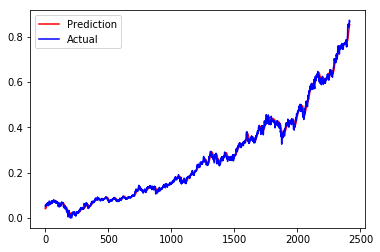

In [18]:
plt.plot(p,color='red', label='Prediction')
plt.plot(y_train,color='blue', label='Actual')
plt.legend(loc='best')
plt.show()

In [19]:
# test data predict
p = model.predict(x_test)
p = [x[0] for x in p]
mse = sum([(p[i] - y_test[i]) ** 2 for i in range(len(p))]) / len(p)
print(mse)

0.0012964845798831824


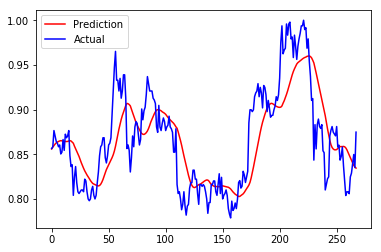

In [20]:
plt.plot(p,color='red', label='Prediction')
plt.plot(y_test,color='blue', label='Actual')
plt.legend(loc='best')
plt.show() 

## Predict growth rate

In [128]:
def shift_close(close_price, window_size):
    shifted_return = (close_price - close_price.shift(window_size)) / (close_price.shift(window_size) + 0.00001)
    shifted_return.dropna(inplace=True)
    shifted_return.reset_index(drop=True, inplace=True)
    return shifted_return

In [135]:
Y = shift_close(input_data.close, 1)[219]
Y = min_max_scaler.fit_transform(input_data.volume.values.reshape(1,-1))
#Y = min_max_scaler.fit_transform(np.array([Y]))
Y

array([[0., 0., 0., ..., 0., 0., 0.]])

In [68]:
# threshold search 二分逼近
def threshold_check_binary(close_price, ratio, low_bound, high_bound, iter_now):
    threshold = (low_bound + high_bound) / 2
    rate = sum(close_price > threshold) / len(close_price)
    if rate == ratio or iter_now == 0:
        return threshold;
    elif rate < ratio:
        return threshold_check(close_price, ratio, low_bound, threshold, iter_now - 1)
    else:
        return threshold_check(close_price, ratio, threshold, high_bound, iter_now - 1)
    

In [69]:
# threshold search 切區段
def threshold_check_segment(close_price, ratio, low_bound, high_bound, section_num):
    threshold = np.linspace(low_bound, high_bound, section_num)
    rate = [sum(close_price > th) / len(close_price) for th in threshold]
    mse = [(r - ratio) ** 2 for r in rate]
    best_rate = threshold[mse.index(min(mse))]
    return best_rate

In [93]:
# growth rate and threshold count
growth_rate = [(p[i + 1] - p[i]) / float(p[i]) for i in range(len(p) - 1)]
y_test_rate = [(y_test[i + 1] - y_test[i]) / float(y_test[i]) for i in range(len(p) - 1)]
Y = shift_close(input_data.close, 1)

threshold_binary = threshold_check_binary(Y, 7/17, 0, 0.1, 100)
threshold_segment = threshold_check_segment(Y, 7/17, 0, 0.1, 100)
print(threshold_binary)

0.004980468750000001


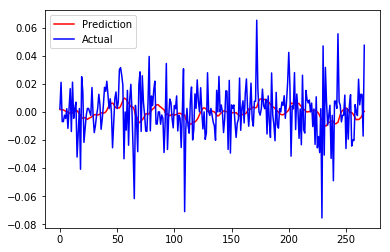

In [94]:
plt.plot(growth_rate,color='red', label='Prediction')
plt.plot(y_test_rate,color='blue', label='Actual')
plt.legend(loc='best')
plt.show() 

In [95]:
y_test_threshold = [1 if y > threshold_binary else 0 for y in y_test_rate]
growth_rate_threshold = [1 if growth > threshold_binary else 0 for growth in growth_rate]
error_rate = sum([y_test_threshold[i] ^ growth_rate_threshold[i] for i in range(len(growth_rate_threshold))]) / len(growth_rate_threshold)